# Classifying Reddit Autos Selfposts with BERT<div class="tocSkip">

&copy; Jens Albrecht, 2023

This notebook can be freely copied and modified.
Attribution, however, is highly appreciated.

<hr/>

See also:

Albrecht, Ramachandran, Winkler: **Blueprints for Text Analytics in Python** (O'Reilly 2020)
Chapter 6: [Text Classification Algorithms](https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch06.html#ch-classification) + [Link to Github](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/README.md)

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2023-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on Google Colab.
Files will be downloaded to "/content".
!wget -P /content/notebooks https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/notebooks/settings.py
!wget -P /content/packages https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/cars.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/__init__.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/exploration.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/preparation.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/embeddings.py
!wget -P /content/data https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/data/reddit-autos-selfposts-cleaned.csv
!wget -P /content/data https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/dat

## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

## Prepare Datasets for Machine Learning

### Load Data

For BERT we will work with the full text only, no preprocessing like stop word removal, lemmatization etc.

In [5]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-prepared.csv", sep=";", decimal=".")
df = df[['subreddit', 'text']]

len(df)

24712

In [6]:
# set display column width unlimited to show full text
pd.set_option('max_colwidth', None)

df.sample(5)

# reset display column width to 30
pd.reset_option('max_colwidth')

,subreddit,text
9244,teslamotors,EVs for apartment dwellers: EVs for apartments dwellers should include a small portable part of the battery (suitcase batteries) that can be carried up into the apartment and given a charge there for say 7 miles. Then perhaps be able to rent or buy several suitcases for expanded range and to take advantage of solid state when it comes out.
12283,motorcycles,New Master Cylinder 13 to 15?: I own a Guzzi v7ii stone and i know the OEM mc is a 13 ​ i saw the nicer Brembo RCS15 and i was told some have installed it on the v7 but i also saw RCS14... and some OEM/third party 13 ​ what is the difference between these few millimeters? how does it impact the braking?
23135,BMW,"Driving my first M: Im 19 and about a year I joined the Bmw family when I got my first car, a 2004 325i. Obviously I fell in love and a year later i'm still in love. Ever since I got into the BMW community it has been a dream of mine to drive an M. I work at luxury car dealership where we have several M's in our inventory and the boss asked if I wanted to kill some time and pick up some food for him and I. I replied ""sure, only if you let me take the X6m"" to which he said ""sure"". Not trying to get my hopes up I played it cool, expecting him to say ""just kidding"". But it became real when he gave me the keys and said ""have fun kid"". At this point I'm in the drivers seat trying to take it all in and finally I take off and OH MY. All I can say is that the car is ANGRY. You give it a little gas and its just roars at you. Pops, burbles. At first I was taking it easy because I was admittedly a little scared to be driving the bosses car. So I'm cruising, or at least I thought I was because I look down at the dash and I'm going 80 and it felt like I was goin half that. The brakes are extremely responsive and smooth, steering was slightly numb compared to my 2004 but its still sharp. Finally I get to some open road and its time to see what this thing can do. You give the car a little gas and you're down the road. Is the F16 X6m the fastest of M's? Absolutely not but its faster than most cars on the road. The thing is a sling shot. A little lag but when it kicks, your head is thrown back against the seat. Straight beast. Body roll is almost non existent. Driving this thing down the road, everyone is breaking there neck to check it out. Then they have to take a double look when they see a 19 year old driving it. It felt good. Just makes me excited for when I get my own. Anyone remember their first time driving an M?"
6351,motorcycles,Choke cable: I'm new to motorcycles but I just bought an '83 Honda shadow 500 and the choke cable is broken. I was wondering if choke cables are specified for bikes per model like an engine or side pieces or if they're just like handlebars and can fit on any. Any help?
6314,motorcycles,"First street bike: Bought a 09 ZX10R: I haven't been on a bike in ages. I grew up riding a KX80, a CR80, a KX125 and finally a pro circuit built KX250. That was mostly in my youth though. I have had the bug to buy a street bike for a long time and I have always had my eyes set on a liter bike. I'm a bigger dude, 6'2, 250 lbs. Also got a wife and kids and in my mid-thirties. The bike is being shipped to be now. I am in no pressure to ride it, I have a full size truck as my main transportation to work and back (Army) and my wife has her own car. I am nervous. I do respect liter bikes. I dont want to get hurt or worst, but I also feel like if I don't get the bike I will live with the regret of not having one like I have for the last 15 years. My mental approach is to baby that thing around, and when I am comfortable, there may be a time and place to stretch it's legs occasionally. As you guys know, the 09 ZX10R has no ABS, power modes, traction, or anything. It's a raw bike. For better or worst I am drawn to that and I think it will make me respect it even more. These years of ninjas are also know for a snappy top end. I have 

### Define Label

Store the label in a variable to make modifications easier.

In [7]:
label = 'subreddit'

In [8]:
df[label].value_counts().to_frame()

,subreddit
motorcycles,5654
AskMechanics,2713
teslamotors,2515
BMW,2303
Audi,2053
Honda,1957
Volkswagen,1657
Hyundai,1433
Toyota,1145
mercedes_benz,1145


### Convert to Huggingface Dataset

In [38]:
import datasets
from datasets import Dataset

ds = Dataset.from_pandas(df[['text', label]]) \
            .rename_column(label, 'label') \
            .class_encode_column("label") # convert to datasets.ClassLabel

Casting to class labels:   0%|          | 0/24712 [00:00<?, ? examples/s]

In [40]:
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 24712
})

In [41]:
ds.features['label']

ClassLabel(names=['AskMechanics', 'Audi', 'BMW', 'Harley', 'Honda', 'Hyundai', 'Toyota', 'Volkswagen', 'Volvo', 'mercedes_benz', 'motorcycles', 'teslamotors'], id=None)

In [44]:
ds['label'][:10]

[10, 6, 4, 1, 11, 11, 1, 8, 11, 11]

In [ ]:
# cl = ds.features['label']
int2str

In [45]:
df[label][:10]

0    motorcycles
1         Toyota
2          Honda
3           Audi
4    teslamotors
5    teslamotors
6           Audi
7          Volvo
8    teslamotors
9    teslamotors
Name: subreddit, dtype: object

## **Tokenization**

### Subword-Tokenization

In [46]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [47]:
text = "I love my BMW i3 but charging with my wallbox could be faster."
encoded_text = tokenizer(text)

encoded_text

{'input_ids': [101, 1045, 2293, 2026, 13154, 1045, 2509, 2021, 13003, 2007, 2026, 2813, 8758, 2071, 2022, 5514, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [48]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

print(*tokens)

[CLS] i love my bmw i ##3 but charging with my wall ##box could be faster . [SEP]


Tokens starting with `##` mark suffixes and should be merged with the preceding token to get the original string representation. The following function does just that:

In [49]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] i love my bmw i3 but charging with my wallbox could be faster. [SEP]'

#### Tokenizing the Whole Dataset

In [50]:
def tokenize(batch):
    return tokenizer(batch['text'],
                     padding=True, # pad examples with zeros to the right
                     truncation=True) # truncate to models maximum context size

In [51]:
tokenize(ds[:2])

{'input_ids': [[101, 2393, 999, 6081, 12501, 2000, 15095, 1024, 2516, 2758, 2009, 2035, 1010, 18546, 12432, 24563, 2007, 6081, 2013, 1037, 6023, 4524, 2008, 2288, 2205, 2485, 1012, 1045, 1005, 2310, 2464, 2367, 15690, 2006, 2536, 21415, 1010, 2559, 2005, 2034, 11774, 3325, 1010, 2054, 1005, 1055, 2499, 2190, 2005, 2017, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2064, 1045, 3531, 2131, 2070, 2393, 6575, 3784, 2005, 1037, 2109, 2482, 2000, 4965, 1029, 1024, 1045, 2052, 2428, 9120, 2009, 1012, 1045, 2424, 2023, 3243, 10827, 1012, 2026, 3976, 2846, 2003, 1002, 11910, 1011, 20143, 1012, 1045, 2113, 2009, 1005, 1055, 2025, 2172, 2021, 1045, 1005, 1049, 372

In [52]:
# for tokenization use one single batch to ensure all tensors have the same shape
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/24712 [00:00<?, ? examples/s]

Now the dataset has two additional attributes: `input_ids` and `attention_mask`.

In [53]:
ds_encoded

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 24712
})

## Classification with BERT as Feature Extractor

### Extracting the Last Hidden States

In [57]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [58]:
model_ckpt

'distilbert-base-uncased'

In [59]:
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
text = ["this is a test", "this is not a test"]
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
inputs['input_ids'].size()

torch.Size([2, 7])

In [61]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         ...,
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619],
         [ 0.0352, -0.3883,  0.0161,  ...,  0.0221,  0.0190,  0.4101]],

        [[-0.0923, -0.0875, -0.0194,  ..., -0.0601,  0.1510,  0.5475],
         [-0.2492, -0.5210, -0.0962,  ..., -0.2267,  0.3294,  0.3957],
         [-0.1805, -0.4085,  0.0953,  ..., -0.0257, -0.0198,  0.7817],
         ...,
         [-0.0915, -0.2593,  0.1829,  ..., -0.0708, -0.1403,  0.7053],
         [ 0.3783, -0.3699, -0.3622,  ..., -0.3398,  0.0264, -0.3225],
         [ 0.9101,  0.0807, -0.4004,  ...,  0.1511, -0.6977, -0.1923]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Two inputs, at most seven tokens (five tokens in second example + `[CLS]` + `[SEP]`), 768-dimensional embeddings:

In [62]:
outputs.last_hidden_state.size()

torch.Size([2, 7, 768])

Embeddings on position 0 (`[CLS]`) can be used as sequence embeddings:

In [63]:
outputs.last_hidden_state[:,0]

tensor([[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
        [-0.0923, -0.0875, -0.0194,  ..., -0.0601,  0.1510,  0.5475]],
       device='cuda:0')

In [64]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return { "hidden_state": last_hidden_state[:,0].cpu().numpy() }

Convert inputs to PyTorch format:

In [67]:
ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Retrieve the sequence embeddings:

In [68]:
ds_embedded = ds_encoded.map(extract_hidden_states, batched=True, batch_size=100) # default is 1000

Map:   0%|          | 0/24712 [00:00<?, ? examples/s]

Transform the embeddings into a NumPy matrix for training:

In [70]:
X_bert = np.array(ds_embedded['hidden_state'])

Now our training data matrix consists of 768-dimensional sequence embeddings:

In [71]:
X_bert.shape

(24712, 768)

In [72]:
np.save("distilbert_embeddings", X_bert)

In [ ]:
# X_bert = np.load("distilbert_embeddings.npy")

### Train-Test-Split

Choose data matrix `X` and label vector `y` for training:

In [73]:
X = X_bert

# define label vector
y = df[label]

Now split with `train_test_split()`.

Recommendation: use `stratify=y`

In [76]:
from sklearn.model_selection import train_test_split

# define holdout
test_size = 0.2

if test_size > 0.0:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        stratify = y,
                                                        random_state=43
                                                       )
else:
    X_train, X_test, y_train, y_test = X, None, y, None


print("Train matrix: ", X_train.shape)
print("Test matrix:  ", X_test.shape)

Train matrix:  (19769, 768)
Test matrix:   (4943, 768)


Store information about train/test records in data frame.

In [77]:
df['train_test'] = pd.Series(df.index.isin(y_test.index)).map(lambda x: 'Test' if x else 'Train')

In [78]:
df['train_test'].value_counts().to_frame()

,train_test
Train,19769
Test,4943


### Training an SVM on BERT embeddings

Training takes about three minutes on Colab.

In [79]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

print(f'Training on column {label}')

clf = LinearSVC(C=1.0)
# clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
# clf = LogisticRegression(max_iter=3000)

clf.fit(X_train, y_train);

print("Done.")

Training on column subreddit


LinearSVC()

Done.


### Evaluation

Apply classifier to test data with `predict()`.

In [80]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f"Classifier: {clf.__class__}\n")

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Classifier: <class 'sklearn.svm._classes.LinearSVC'>

Accuracy Summary
Test:     72.55%
Train:    81.44%


about 14% worse than TF-IDF!

Looking at the per-class metrics with `classification_report`:

In [81]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

Classification Report
               precision    recall  f1-score   support

 AskMechanics       0.62      0.67      0.65       543
         Audi       0.76      0.73      0.75       411
          BMW       0.68      0.68      0.68       461
       Harley       0.61      0.45      0.52       220
        Honda       0.69      0.69      0.69       391
      Hyundai       0.71      0.77      0.74       287
       Toyota       0.65      0.63      0.64       229
   Volkswagen       0.62      0.60      0.61       331
        Volvo       0.62      0.57      0.60       207
mercedes_benz       0.59      0.45      0.51       229
  motorcycles       0.84      0.89      0.87      1131
  teslamotors       0.83      0.88      0.85       503

     accuracy                           0.73      4943
    macro avg       0.69      0.67      0.67      4943
 weighted avg       0.72      0.73      0.72      4943



Let's see if we can do better when we fine-tune the model!

### Fine-Tuning the BERT Model

### Train-Test Split

The dataset function `train_test_split` works similar to the function from Scikit-learn, except that it returns a dictionary of type `DatasetDict` containing the train and the test data set:

In [88]:
import datasets
# from datasets import Dataset, DatasetDict, ClassLabel

ds_tt = ds_encoded.train_test_split(test_size=0.2)
ds_tt

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 19769
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4943
    })
})

### Load the Base Model

Now we have to load the model that we want to fine-tune. We stick with this one:

In [ ]:
model_ckpt

`AutoModelForSequenceClassification` comes with a classification head which can be trained with the base outputs.

In [92]:
from transformers import AutoModelForSequenceClassification

print(f'Loading {model_ckpt} to {device}...\n')
num_labels = len(ds_encoded.features['label'].names)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
model

Loading distilbert-base-uncased to cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.we

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [93]:
# define performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return { "accuracy": acc, "f1": f1 }

In [97]:
import transformers
from transformers import Trainer, TrainingArguments

transformers.logging.set_verbosity_info() # set log level to INFO

batch_size = 32
logging_steps = len(ds_tt['train'])//batch_size
model_name = f"{model_ckpt}-finetuned-autos"
model_name

'distilbert-base-uncased-finetuned-autos'

In [99]:
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error"
                                  )

Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Training takes about seven minutes on Colab.

In [101]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_tt['train'],
                  eval_dataset=ds_tt['test'])
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.941400,0.444528,0.873154,0.873131
2,0.385200,0.371451,0.890350,0.889473


TrainOutput(global_step=1236, training_loss=0.6625609420794499, metrics={'train_runtime': 473.4025, 'train_samples_per_second': 83.519, 'train_steps_per_second': 2.611, 'total_flos': 5238430041120768.0, 'train_loss': 0.6625609420794499, 'epoch': 2.0})

Let's see if we can improve a little further:

In [102]:
trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss,Accuracy,F1
2,0.323700,0.373980,0.889743,0.889248


TrainOutput(global_step=1236, training_loss=0.06174726123562908, metrics={'train_runtime': 100.5402, 'train_samples_per_second': 393.256, 'train_steps_per_second': 12.294, 'total_flos': 5238430041120768.0, 'train_loss': 0.06174726123562908, 'epoch': 2.0})

### Evaluation

For the evaluation we can apply the classifier with `predict()`.

In [104]:
pred_test = trainer.predict(ds_tt['test'])
pred_train = trainer.predict(ds_tt['train'])

Prediction outputs contains model output, label_ids and metrics:

In [105]:
pred_test

PredictionOutput(predictions=array([[ 1.9173275 , -0.6217162 , -0.6621114 , ..., -1.219221  ,
        -0.9976016 , -1.3156343 ],
       [ 1.4006816 , -1.1335255 , -1.2322953 , ..., -1.4809031 ,
         5.506841  , -1.214903  ],
       [-0.1283087 , -0.18857981,  5.4094405 , ..., -0.2867245 ,
        -0.52689   , -0.7997853 ],
       ...,
       [ 1.2395147 , -1.759818  , -1.1988113 , ..., -0.7093214 ,
        -1.266651  , -0.39687565],
       [ 0.83117265, -1.1853819 , -0.92243046, ..., -0.3632293 ,
        -1.6541276 , -0.18634613],
       [ 0.58079815,  3.1039546 , -0.29884154, ..., -1.3511018 ,
         2.0078967 , -1.344508  ]], dtype=float32), label_ids=array([ 4, 10,  2, ...,  6,  5, 10]), metrics={'test_loss': 0.37397998571395874, 'test_accuracy': 0.8897430710095084, 'test_f1': 0.8892475455588565, 'test_runtime': 17.5566, 'test_samples_per_second': 281.547, 'test_steps_per_second': 8.829})

In [107]:
pred_test.metrics

{'test_loss': 0.37397998571395874,
 'test_accuracy': 0.8897430710095084,
 'test_f1': 0.8892475455588565,
 'test_runtime': 17.5566,
 'test_samples_per_second': 281.547,
 'test_steps_per_second': 8.829}

We can get the actual predictions for each sample with `argmax`:

In [113]:
y_test_pred = pred_test.predictions.argmax(-1)
y_train_pred = pred_train.predictions.argmax(-1)

Let's retrieve the label-ids

In [115]:
y_test = pred_test.label_ids
y_train = pred_train.label_ids

With the help of the `ClassLabel` object we convert the ids back to string labels:

In [119]:
cl = ds.features['label']

for i in range(len(cl.names)):
    print(f"{i:2} --> {cl.int2str(i)}")

 0 --> AskMechanics
 1 --> Audi
 2 --> BMW
 3 --> Harley
 4 --> Honda
 5 --> Hyundai
 6 --> Toyota
 7 --> Volkswagen
 8 --> Volvo
 9 --> mercedes_benz
10 --> motorcycles
11 --> teslamotors


In [120]:
y_test = pd.Series(y_test).map(cl.int2str)
y_test_pred = pd.Series(y_test_pred).map(cl.int2str)

y_train = pd.Series(y_train).map(cl.int2str)
y_train_pred = pd.Series(y_train_pred).map(cl.int2str)

In [122]:
from sklearn.metrics import accuracy_score

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Accuracy Summary
Test:     88.97%
Train:    91.95%


Much better, over 16% increase and slightly beating TF-IDF/SVM!

Looking at the per-class metrics with `classification_report`:

In [123]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

Classification Report
               precision    recall  f1-score   support

 AskMechanics       0.77      0.76      0.77       531
         Audi       0.95      0.94      0.94       420
          BMW       0.96      0.91      0.94       468
       Harley       0.77      0.69      0.73       232
        Honda       0.89      0.87      0.88       406
      Hyundai       0.91      0.91      0.91       257
       Toyota       0.85      0.83      0.84       226
   Volkswagen       0.86      0.90      0.88       337
        Volvo       0.94      0.94      0.94       202
mercedes_benz       0.88      0.91      0.89       256
  motorcycles       0.91      0.93      0.92      1110
  teslamotors       0.92      0.96      0.94       498

     accuracy                           0.89      4943
    macro avg       0.89      0.88      0.88      4943
 weighted avg       0.89      0.89      0.89      4943



### Confusion Matrix

In [125]:
cl.names

['AskMechanics',
 'Audi',
 'BMW',
 'Harley',
 'Honda',
 'Hyundai',
 'Toyota',
 'Volkswagen',
 'Volvo',
 'mercedes_benz',
 'motorcycles',
 'teslamotors']

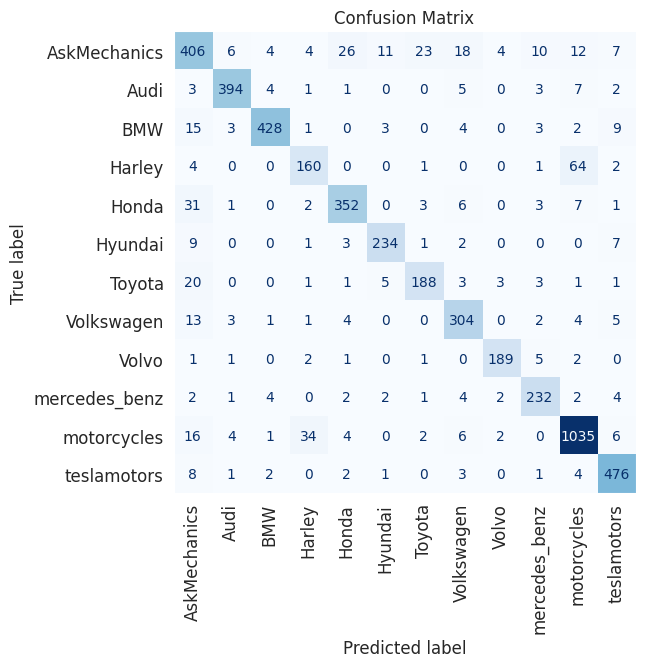

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize=None) # or None
    fig, ax = plt.subplots(figsize=(6, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".0f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


# label names - specifies order in confusion matrix
label_names = cl.names

plot_confusion_matrix(y_test, y_test_pred, label_names)

This was the TF-IDF confusion matrix:
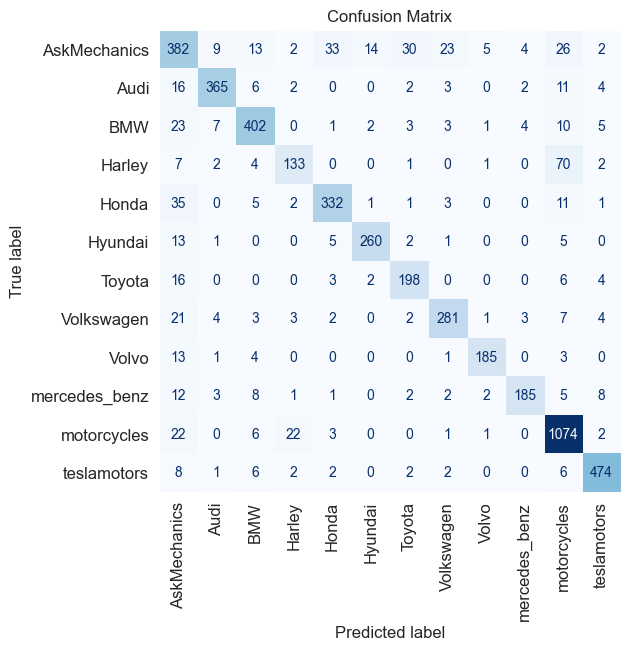